In [1]:
import os
import copy
import time
import pickle
import numpy as np
from torch.utils import data
from tqdm import tqdm
import torch
from options import args_parser
from update import LocalUpdate, test_inference
from models.imagenet import resnext50
from utils import get_dataset, average_weights, exp_details
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
start_time = time.time()
data_dir='/home/hh239/ece685/data/imagenette2'
dataset='imagenet'
local_ep = 5
local_bs = 16
num_users = 5
epochs = 42
frac = 1
iid = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # load dataset and user groups
# train_dataset, test_dataset, user_groups = get_dataset(
#     data_dir=data_dir, 
#     dataset=dataset, 
#     num_users=num_users, 
#     iid=iid
# )

# # BUILD MODEL
# global_model = resnext50(
#     baseWidth=4,
#     cardinality=32)

# # Set the model to train and send it to device.
# if torch.cuda.is_available():
#     global_model = torch.nn.DataParallel(global_model).cuda()
# else:
#     global_model.to(device)

# file_name = './results'+\
#     f'/imagenet_resnext_{epochs}_C[{frac}]_iid[{iid}]_E[{local_ep}]_B[{local_bs}].pkl'

# with open(file_name, 'rb') as f:
#     logger = pickle.load(f)

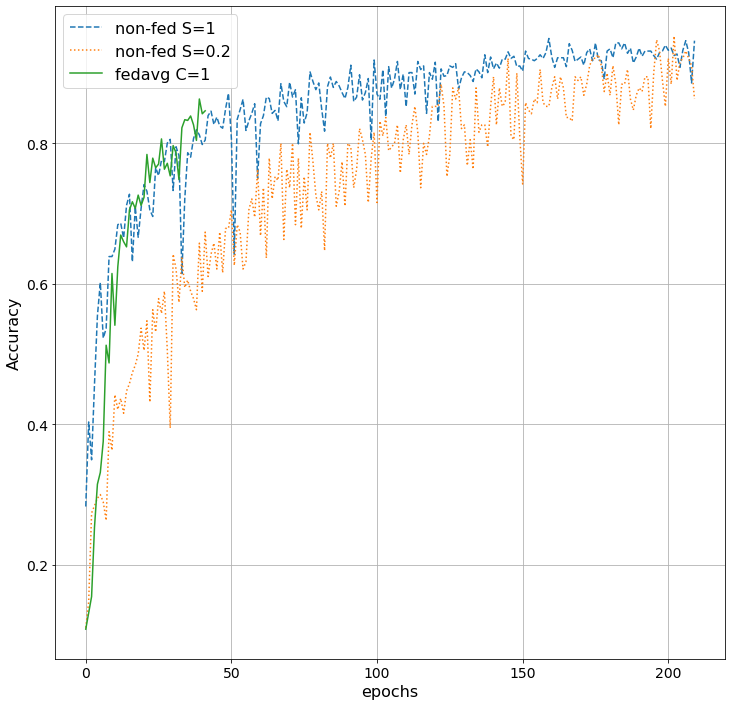

In [5]:
fig, ax = plt.subplots(figsize=(12, 12))
file_name = './results'+f'/imagenet_resnext_210_S[1]_iid[1]_E[5]_B[16].pkl'
with open(file_name, 'rb') as f:
    logger = pickle.load(f)
acc = logger['acc']
x = np.arange(0, 210)
plt.plot(x, acc, label='non-fed S=1', linestyle='dashed')

file_name = './results'+f'/imagenet_resnext_210_S[0.2]_iid[1]_E[5]_B[16].pkl'
with open(file_name, 'rb') as f:
    logger = pickle.load(f)
acc = logger['acc']
plt.plot(x, acc, label='non-fed S=0.2', linestyle='dotted')

x = np.arange(0, 42)
file_name = './results'+f'/imagenet_resnext_42_C[1]_iid[1]_E[5]_B[16].pkl'
with open(file_name, 'rb') as f:
    logger = pickle.load(f)
acc = logger['acc']
plt.plot(x, acc, label='fedavg C=1', linestyle='solid')

plt.xlabel('epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.grid()
plt.savefig('results/fedavg_vs_nonfed.png', dpi=300)
plt.show()

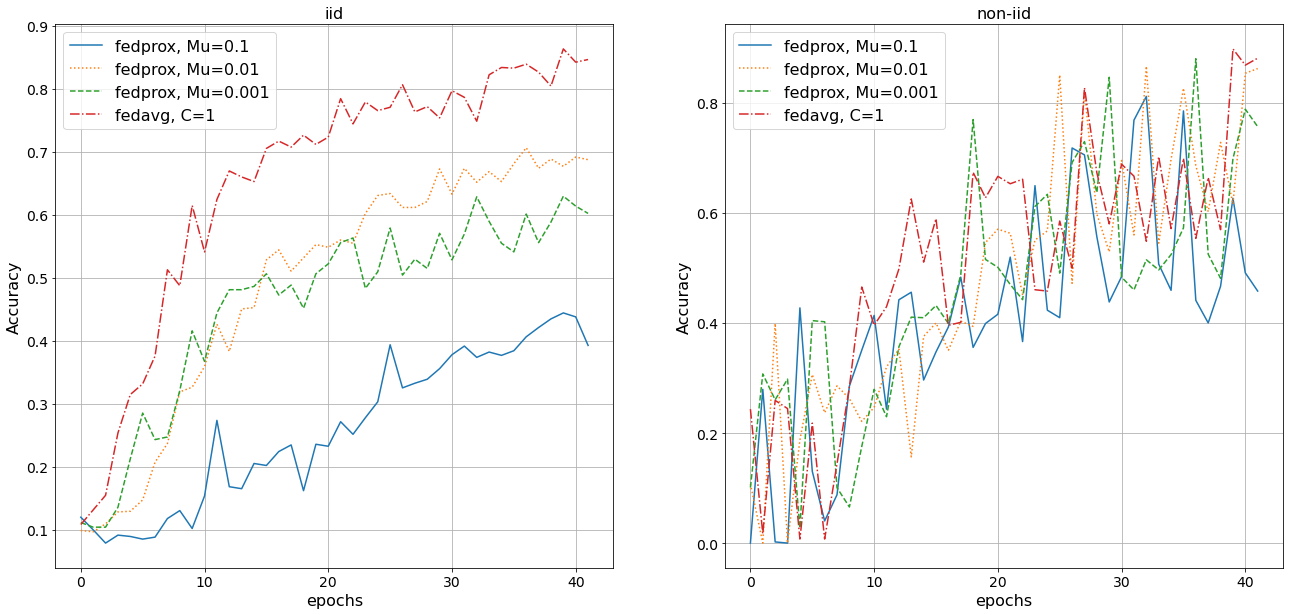

In [6]:
epochs = 42
mu = [0.1, 0.01, 0.001]
linestyles = ['solid', 'dotted', 'dashed', 'dashdot', 'solid']
x = np.arange(42)

fig, ax = plt.subplots(1, 2, figsize=(22, 10))

for i, m in enumerate(mu):
    file_name = './results'+f'/imagenet_resnext_fedprox_Mu[{m}]_{epochs}_C[1]_iid[1]_E[{local_ep}]_B[{local_bs}].pkl'
    with open(file_name, 'rb') as f:
        logger = pickle.load(f)
    acc = logger['acc']
    ax[0].plot(x, acc, label=f'fedprox, Mu={m}', linestyle=linestyles[i])

file_name = './results'+f'/imagenet_resnext_{epochs}_C[1]_iid[1]_E[{local_ep}]_B[{local_bs}].pkl'
with open(file_name, 'rb') as f:
    logger = pickle.load(f)
acc = logger['acc']
ax[0].plot(x, acc, label=f'fedavg, C=1', linestyle='dashdot')

ax[0].set_xlabel('epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].set_title('iid', fontsize=16)
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=14)
ax[0].legend(fontsize=16)
ax[0].grid()

for i, m in enumerate(mu):
    file_name = './results'+f'/imagenet_resnext_fedprox_Mu[{m}]_{epochs}_C[1]_iid[0]_E[{local_ep}]_B[{local_bs}].pkl'
    with open(file_name, 'rb') as f:
        logger = pickle.load(f)
    acc = logger['acc']
    ax[1].plot(x, acc, label=f'fedprox, Mu={m}', linestyle=linestyles[i])

file_name = './results'+f'/imagenet_resnext_fedavg_Mu[0.01]_{epochs}_C[1]_iid[0]_E[{local_ep}]_B[{local_bs}].pkl'
with open(file_name, 'rb') as f:
    logger = pickle.load(f)
acc = logger['acc']
ax[1].plot(x, acc, label=f'fedavg, C=1', linestyle='dashdot')

ax[1].set_xlabel('epochs', fontsize=16)
ax[1].set_ylabel('Accuracy', fontsize=16)
ax[1].set_title('non-iid', fontsize=16)
ax[1].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='y', labelsize=14)
ax[1].legend(fontsize=16)
ax[1].grid()

plt.savefig('results/fedprox_fedavg.png', dpi=300)
plt.show()

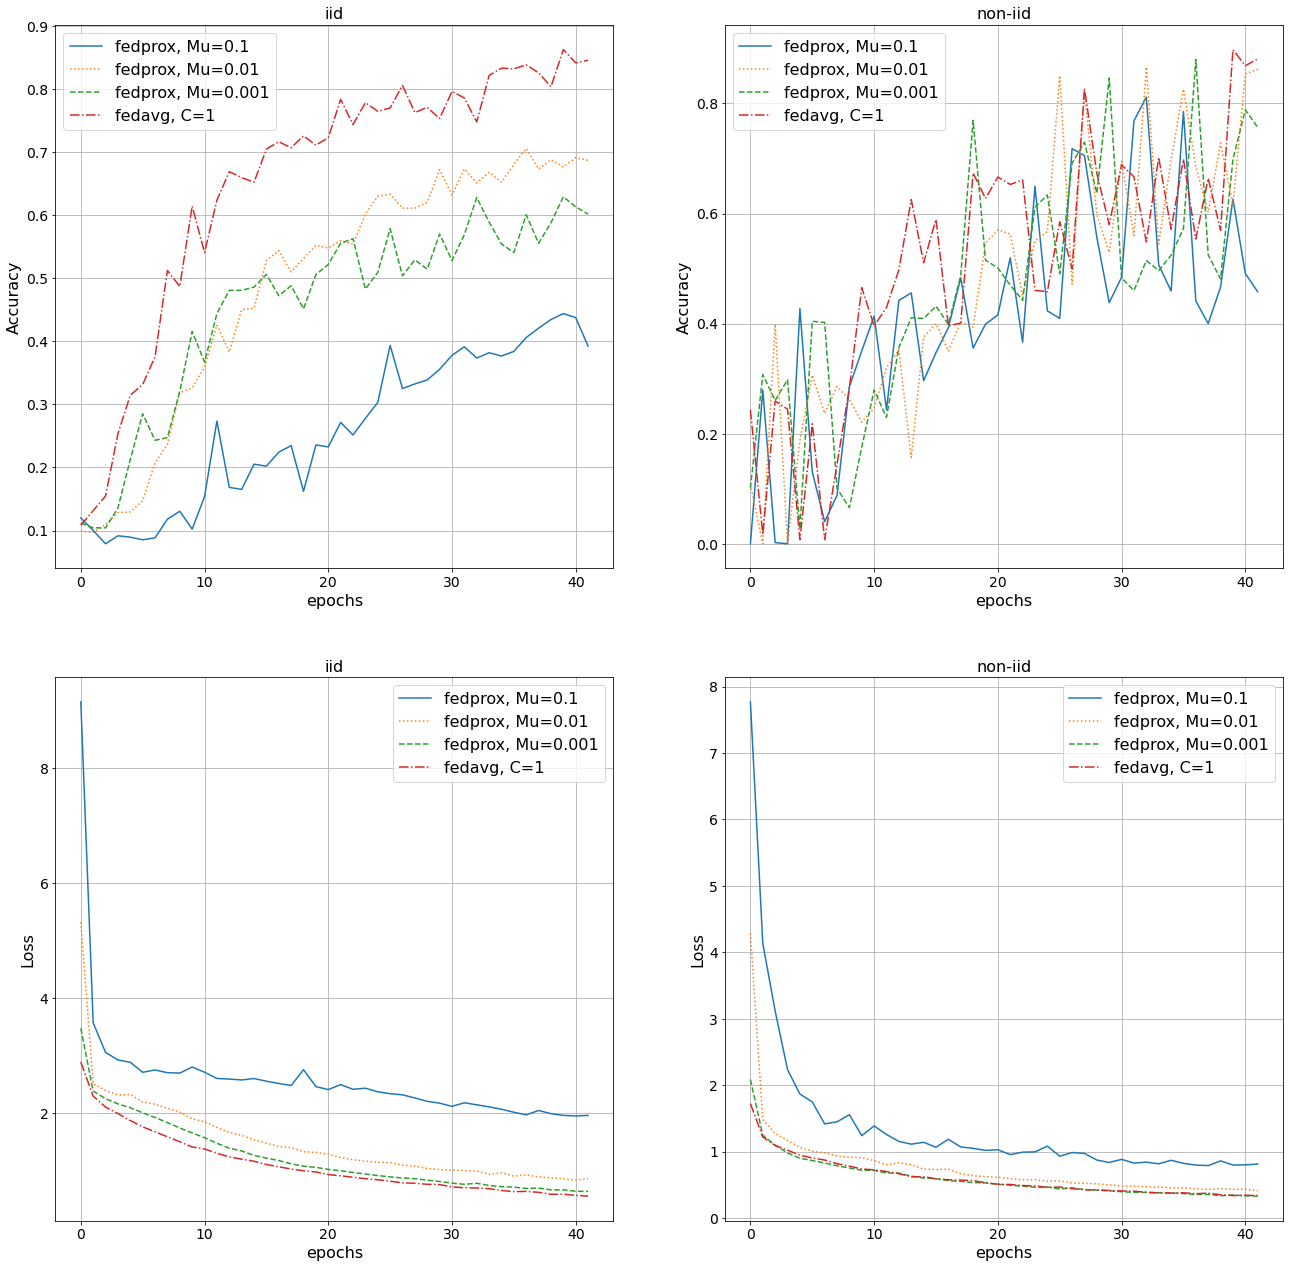

In [8]:
epochs = 42
mu = [0.1, 0.01, 0.001]
linestyles = ['solid', 'dotted', 'dashed', 'dashdot', 'solid']
x = np.arange(42)

fig, ax = plt.subplots(2, 2, figsize=(22, 22))

for i, m in enumerate(mu):
    file_name = './results'+f'/imagenet_resnext_fedprox_Mu[{m}]_{epochs}_C[1]_iid[1]_E[{local_ep}]_B[{local_bs}].pkl'
    with open(file_name, 'rb') as f:
        logger = pickle.load(f)
    acc = logger['acc']
    ax[0,0].plot(x, acc, label=f'fedprox, Mu={m}', linestyle=linestyles[i])

file_name = './results'+f'/imagenet_resnext_{epochs}_C[1]_iid[1]_E[{local_ep}]_B[{local_bs}].pkl'
with open(file_name, 'rb') as f:
    logger = pickle.load(f)
acc = logger['acc']
ax[0,0].plot(x, acc, label=f'fedavg, C=1', linestyle='dashdot')

ax[0,0].set_xlabel('epochs', fontsize=16)
ax[0,0].set_ylabel('Accuracy', fontsize=16)
ax[0,0].set_title('iid', fontsize=16)
ax[0,0].tick_params(axis='x', labelsize=14)
ax[0,0].tick_params(axis='y', labelsize=14)
ax[0,0].legend(fontsize=16)
ax[0,0].grid()

for i, m in enumerate(mu):
    file_name = './results'+f'/imagenet_resnext_fedprox_Mu[{m}]_{epochs}_C[1]_iid[0]_E[{local_ep}]_B[{local_bs}].pkl'
    with open(file_name, 'rb') as f:
        logger = pickle.load(f)
    acc = logger['acc']
    ax[0,1].plot(x, acc, label=f'fedprox, Mu={m}', linestyle=linestyles[i])

file_name = './results'+f'/imagenet_resnext_fedavg_Mu[0.01]_{epochs}_C[1]_iid[0]_E[{local_ep}]_B[{local_bs}].pkl'
with open(file_name, 'rb') as f:
    logger = pickle.load(f)
acc = logger['acc']
ax[0,1].plot(x, acc, label=f'fedavg, C=1', linestyle='dashdot')

ax[0,1].set_xlabel('epochs', fontsize=16)
ax[0,1].set_ylabel('Accuracy', fontsize=16)
ax[0,1].set_title('non-iid', fontsize=16)
ax[0,1].tick_params(axis='x', labelsize=14)
ax[0,1].tick_params(axis='y', labelsize=14)
ax[0,1].legend(fontsize=16)
ax[0,1].grid()


for i, m in enumerate(mu):
    file_name = './results'+f'/imagenet_resnext_fedprox_Mu[{m}]_{epochs}_C[1]_iid[1]_E[{local_ep}]_B[{local_bs}].pkl'
    with open(file_name, 'rb') as f:
        logger = pickle.load(f)
    acc = logger['loss']
    ax[1,0].plot(x, acc, label=f'fedprox, Mu={m}', linestyle=linestyles[i])

file_name = './results'+f'/imagenet_resnext_{epochs}_C[1]_iid[1]_E[{local_ep}]_B[{local_bs}].pkl'
with open(file_name, 'rb') as f:
    logger = pickle.load(f)
acc = logger['loss']
ax[1,0].plot(x, acc, label=f'fedavg, C=1', linestyle='dashdot')

ax[1,0].set_xlabel('epochs', fontsize=16)
ax[1,0].set_ylabel('Loss', fontsize=16)
ax[1,0].set_title('iid', fontsize=16)
ax[1,0].tick_params(axis='x', labelsize=14)
ax[1,0].tick_params(axis='y', labelsize=14)
ax[1,0].legend(fontsize=16)
ax[1,0].grid()

for i, m in enumerate(mu):
    file_name = './results'+f'/imagenet_resnext_fedprox_Mu[{m}]_{epochs}_C[1]_iid[0]_E[{local_ep}]_B[{local_bs}].pkl'
    with open(file_name, 'rb') as f:
        logger = pickle.load(f)
    acc = logger['loss']
    ax[1,1].plot(x, acc, label=f'fedprox, Mu={m}', linestyle=linestyles[i])

file_name = './results'+f'/imagenet_resnext_fedavg_Mu[0.01]_{epochs}_C[1]_iid[0]_E[{local_ep}]_B[{local_bs}].pkl'
with open(file_name, 'rb') as f:
    logger = pickle.load(f)
acc = logger['loss']
ax[1,1].plot(x, acc, label=f'fedavg, C=1', linestyle='dashdot')

ax[1,1].set_xlabel('epochs', fontsize=16)
ax[1,1].set_ylabel('Loss', fontsize=16)
ax[1,1].set_title('non-iid', fontsize=16)
ax[1,1].tick_params(axis='x', labelsize=14)
ax[1,1].tick_params(axis='y', labelsize=14)
ax[1,1].legend(fontsize=16)
ax[1,1].grid()

plt.savefig('results/fedprox_fedavg_acc_loss.png', dpi=300)
plt.show()

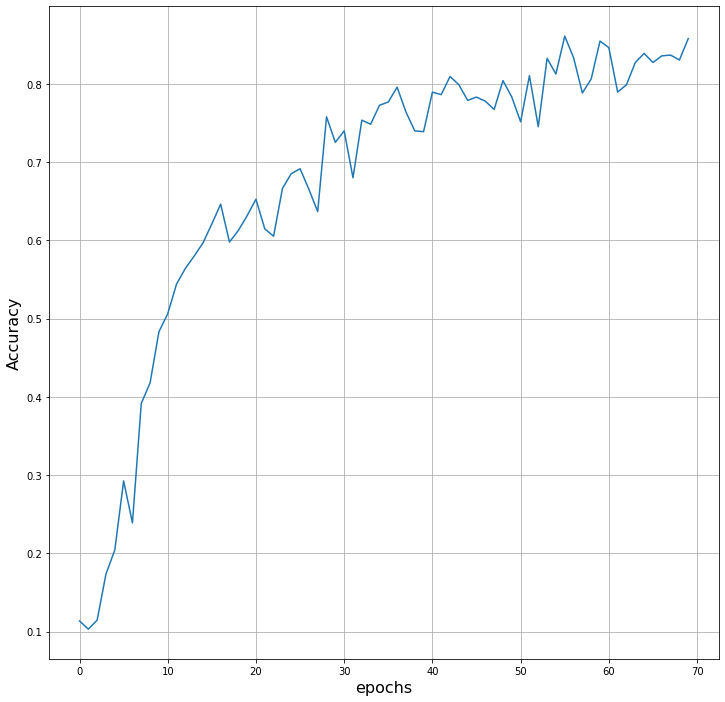

In [3]:
acc = logger['acc']
x = np.arange(epochs)

fig, ax = plt.subplots(figsize=(12, 12))
plt.plot(x, acc)
plt.xlabel('epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.grid()
plt.savefig('results/fedaverage_acc.png', dpi=300)
plt.show()

In [ ]:
len(trainset)



### plot 1/5 baseline train

In [23]:
start_time = time.time()
data_dir='../data/imagenette2'
dataset='imagenet'
local_ep = 5
local_bs = 16
num_users = 1
epochs = 210
frac = 0.2
iid = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load dataset and user groups
train_dataset, test_dataset, _ = get_dataset(
    data_dir=data_dir,
    dataset=dataset,
    num_users=num_users,
    iid=iid
)

# BUILD MODEL
base_model = resnext50(
    baseWidth=4,
    cardinality=32)

# Set the model to train and send it to device.
if torch.cuda.is_available():
    base_model = torch.nn.DataParallel(base_model).cuda()
else:
    base_model.to(device)

file_name = './results'+\
    f'/imagenet_resnext_{epochs}_S[{frac}]_iid[{iid}]_E[{local_ep}]_B[{local_bs}].pkl'

with open(file_name, 'rb') as f:
    logger = pickle.load(f)


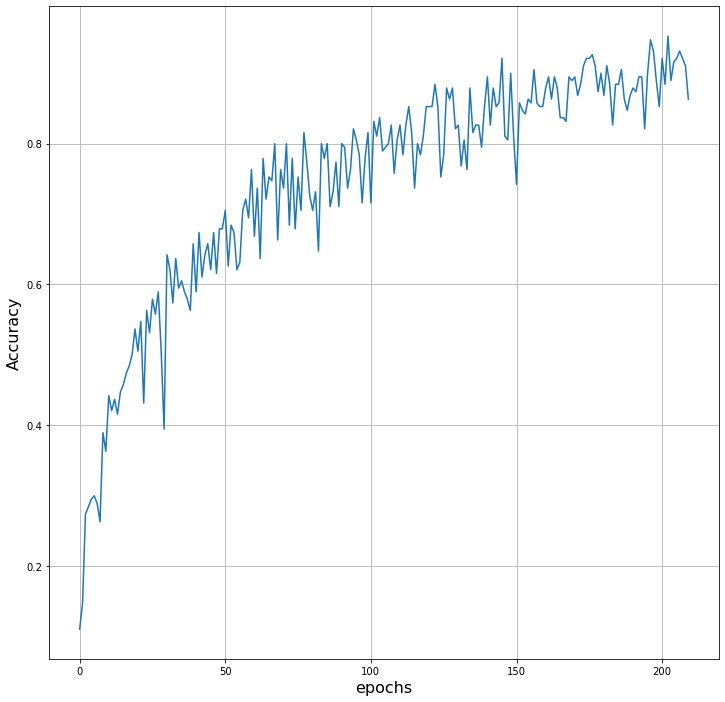

In [24]:
acc = logger['acc']
x = np.arange(epochs)

fig, ax = plt.subplots(figsize=(12, 12))
plt.plot(x, acc)
plt.xlabel('epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.grid()
plt.savefig('results/subset_base_average_acc.png', dpi=300)
plt.show()


In [25]:
train_accuracy = logger['acc']
base_statedict = logger['weights']


base_model.load_state_dict(base_statedict)
base_model.eval()
test_acc, test_loss = test_inference(_, base_model, test_dataset)

print(f' \n Results after 210 baseline rounds of training:')
print("|---- Avg Train Accuracy: {:.2f}%".format(100 * train_accuracy[-1]))
print("|---- Test Accuracy: {:.2f}%".format(100 * test_acc))



RuntimeError: CUDA out of memory. Tried to allocate 196.00 MiB (GPU 0; 10.76 GiB total capacity; 9.74 GiB already allocated; 0 bytes free; 9.82 GiB reserved in total by PyTorch)

### plot full baseline

In [17]:
start_time = time.time()
data_dir='../data/imagenette2'
dataset='imagenet'
local_ep = 5
local_bs = 16
num_users = 1
epochs = 210
frac = 1
iid = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load dataset and user groups
train_dataset, test_dataset, _ = get_dataset(
    data_dir=data_dir,
    dataset=dataset,
    num_users=num_users,
    iid=iid
)

# BUILD MODEL
base_model = resnext50(
    baseWidth=4,
    cardinality=32)

# Set the model to train and send it to device.
if torch.cuda.is_available():
    base_model = torch.nn.DataParallel(base_model).cuda()
else:
    base_model.to(device)

file_name = './results'+\
    f'/imagenet_resnext_{epochs}_S[{frac}]_iid[{iid}]_E[{local_ep}]_B[{local_bs}].pkl'

with open(file_name, 'rb') as f:
    logger = pickle.load(f)


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.76 GiB total capacity; 9.90 GiB already allocated; 0 bytes free; 9.91 GiB reserved in total by PyTorch)

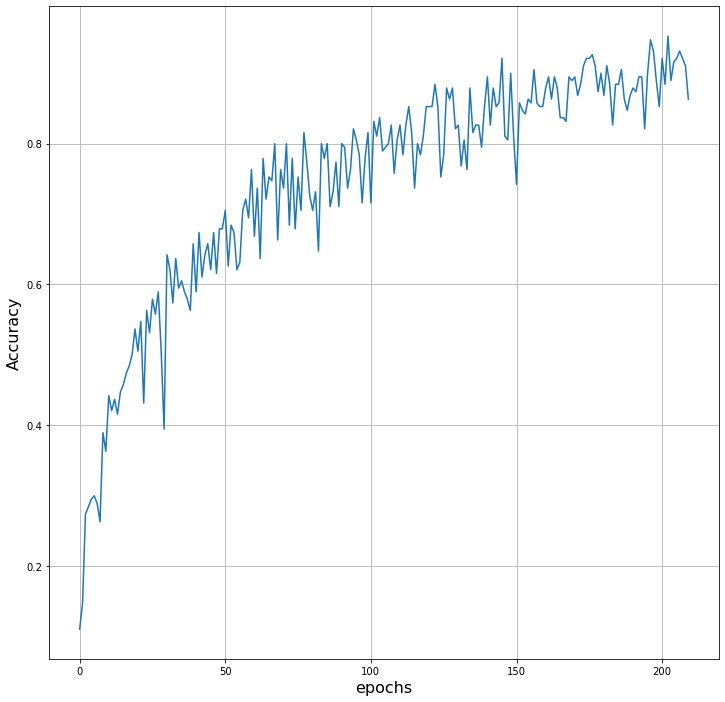

In [20]:
acc = logger['acc']
x = np.arange(epochs)

fig, ax = plt.subplots(figsize=(12, 12))
plt.plot(x, acc)
plt.xlabel('epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.grid()
plt.savefig('results/full_base_average_acc.png', dpi=300)
plt.show()